In [10]:
def progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Number of clusters: 12680
Number of merged clusters: 136


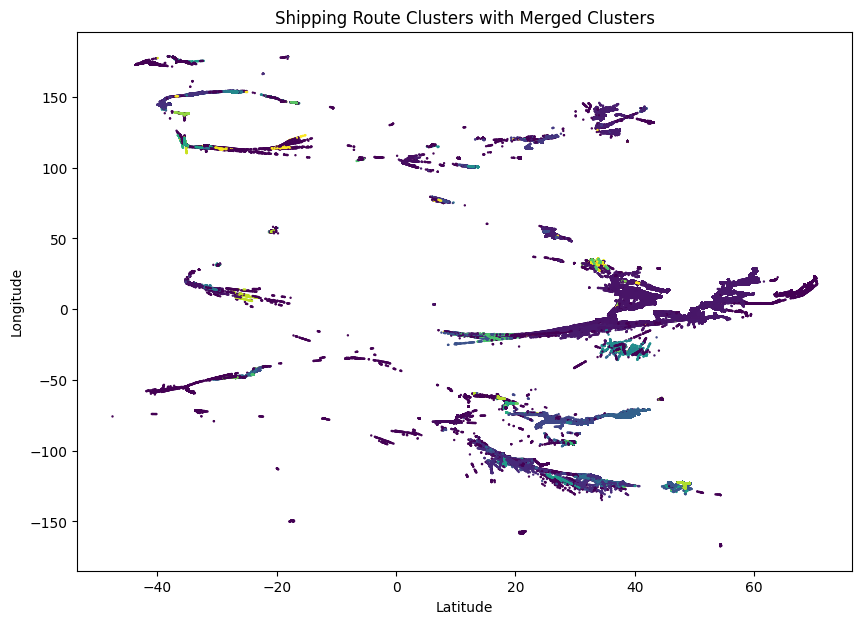

In [12]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# surpress setting with copy warning
pd.options.mode.chained_assignment = None

# Load dataset
X_train = pd.read_csv('../data/ais_train.csv', sep='|')

# Function to convert time to seconds since January 1st, 2024
def convert_to_seconds_since_2024(df, time_column):
    reference_time = pd.Timestamp('2024-01-01 00:00:00')
    df['time_numeric'] = (pd.to_datetime(df[time_column]) - reference_time).dt.total_seconds()
    return df

# Convert 'time' column to seconds since January 1st, 2024
X_train = convert_to_seconds_since_2024(X_train, 'time')

# Function to perform DBSCAN clustering for each vessel
def dbscan_for_each_vessel(data, eps=0.05, min_samples=10):
    clusters = []
    i = 0
    n_iter = len(data['vesselId'].unique())
    for vessel_id in data['vesselId'].unique():
        vessel_data = data[data['vesselId'] == vessel_id]
        
        # Apply DBSCAN directly on the vessel's data
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        cluster_labels = dbscan.fit_predict(vessel_data[['latitude', 'longitude', 'time_numeric']])
        
        # Make the cluster labels strings and add the vessel ID to the cluster labels
        cluster_labels = cluster_labels.astype(str)
        cluster_labels = [f'{vessel_id}_{label}' for label in cluster_labels]

        # Assign the cluster labels back to the vessel's data
        vessel_data['cluster'] = cluster_labels
        clusters.append(vessel_data)


        i += 1
        progress_bar(i, n_iter, prefix='Progress:', suffix='Complete', length=50)
    
    # Combine all clustered vessel data back into a single DataFrame
    return pd.concat(clusters)

# Function to calculate centroids of clusters
def calculate_centroids(df):
    centroids = df.groupby('cluster')[['latitude', 'longitude', 'time_numeric']].mean()
    return centroids

# Function to merge clusters using DBSCAN on centroids
def merge_clusters(centroids, eps=0.1, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    centroids['merged_cluster'] = dbscan.fit_predict(centroids[['latitude', 'longitude', 'time_numeric']])
    return centroids

# Extract relevant features (latitude, longitude, time) and vesselId
route_data = X_train[['latitude', 'longitude', 'time_numeric', 'vesselId']]

# Scaling the latitude, longitude, and time for clustering
scaler = StandardScaler()
route_data.loc[:, ['latitude', 'longitude', 'time_numeric']] = scaler.fit_transform(route_data[['latitude', 'longitude', 'time_numeric']])

# Perform DBSCAN clustering for each vessel
route_data = dbscan_for_each_vessel(route_data, eps=0.05, min_samples=10)

# print the number of clusters
print(f'Number of clusters: {route_data["cluster"].nunique()}')

# Calculate centroids for each cluster
centroids = calculate_centroids(route_data)

# Merge clusters based on proximity of centroids
merged_centroids = merge_clusters(centroids, eps=0.1, min_samples=5)

# Update route_data with merged cluster labels
cluster_mapping = dict(merged_centroids['merged_cluster'])
route_data['merged_cluster'] = route_data['cluster'].map(cluster_mapping)

# print the number of merged clusters
print(f'Number of merged clusters: {route_data["merged_cluster"].nunique()}')

# Inverse transform to get back the original lat/lon/time values for plotting
route_data[['latitude', 'longitude', 'time_numeric']] = scaler.inverse_transform(route_data[['latitude', 'longitude', 'time_numeric']])

# Plot the clustering results with merged clusters
plt.figure(figsize=(10, 7))
plt.scatter(route_data['latitude'], route_data['longitude'], c=route_data['merged_cluster'], cmap='viridis', s=0.5)
plt.title("Shipping Route Clusters with Merged Clusters")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def visualize_vessel_clusters_divided_world(df, sample_frac=0.1, grid_rows=5, grid_cols=10, dir = '../images/', cluster_col='cluster'):
    """
    Visualize vessel clusters by dividing the world into smaller grid regions.

    Parameters:
    - df (pandas.DataFrame): DataFrame with columns ['latitude', 'longitude', 'cluster'].
    - sample_frac (float): Fraction of the data to sample for visualization.
    - grid_rows (int): Number of horizontal divisions (latitude-wise).
    - grid_cols (int): Number of vertical divisions (longitude-wise).

    Returns:
    - Saves multiple plot images for each region.
    """

    # Sample the data for faster visualization
    df_sampled = df.sample(frac=sample_frac, random_state=42)

    # Determine latitude and longitude boundaries
    lat_min, lat_max = -90, 90
    lon_min, lon_max = -180, 180

    # Create latitude and longitude intervals
    lat_intervals = np.linspace(lat_min, lat_max, grid_rows + 1)
    lon_intervals = np.linspace(lon_min, lon_max, grid_cols + 1)

    # Loop through each region and plot clusters for that region
    region_count = 0
    for i in range(grid_rows):
        for j in range(grid_cols):
            lat_start, lat_end = lat_intervals[i], lat_intervals[i + 1]
            lon_start, lon_end = lon_intervals[j], lon_intervals[j + 1]

            # Filter the data for the current region
            region_data = df_sampled[(df_sampled['latitude'] >= lat_start) & (df_sampled['latitude'] < lat_end) &
                                     (df_sampled['longitude'] >= lon_start) & (df_sampled['longitude'] < lon_end)]

            if region_data.empty:
                continue  # Skip empty regions

            # Initialize the plot for the current region
            fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_start, lon_end, lat_start, lat_end], crs=ccrs.PlateCarree())
            
            # Add geographical features
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.LAND, edgecolor='black')
            ax.add_feature(cfeature.OCEAN)

            # Plot each cluster with a different color
            unique_clusters = region_data[cluster_col].unique()
            for cluster in unique_clusters:
                cluster_data = region_data[region_data[cluster_col] == cluster]
                ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', s=1, transform=ccrs.PlateCarree())

            # Add title and legend
            ax.set_title(f'Region {region_count + 1}: [{lat_start}° to {lat_end}°, {lon_start}° to {lon_end}°]', fontsize=14)
            ax.legend(markerscale=5, fontsize=8, loc='upper left')

            # Save each region's plot as a PNG file
            plt.savefig(f'{dir}vessel_clusters_region_{region_count + 1}.png', dpi=300)
            plt.close(fig)

            # Increment region count
            region_count += 1

In [19]:
# Visualize the vessel clusters for vessel
vessel_id = '61e9f429b937134a3c4c00e5'
vessel_data = route_data[route_data['vesselId'] == vessel_id]
visualize_vessel_clusters_divided_world(vessel_data, sample_frac=1, grid_rows=10, grid_cols=10, dir = '../images/', cluster_col='merged_cluster')

In [20]:
# add 'merged_cluster' to X_train. merge on 'vesselId' and 'time_numeric'
X_train = X_train.merge(route_data[['vesselId', 'time_numeric', 'merged_cluster']], on=['vesselId', 'time_numeric'], how='left')

In [22]:
X_train.to_csv('../data/ais_train_clustered.csv', index=False)

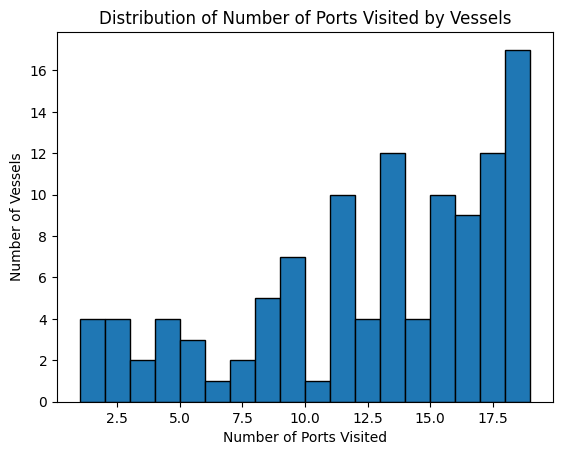

In [6]:
n_ports = np.zeros(len(train['vesselId'].unique()))

for i, vessel in enumerate(train['vesselId'].unique()):
    n_ports[i] = len(train[train['vesselId'] == vessel]['portId'].unique())

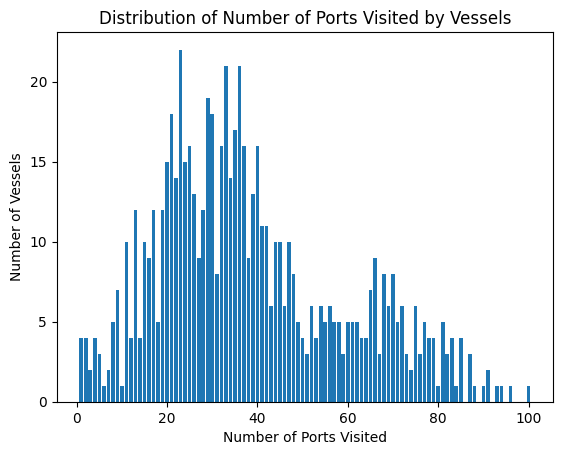

In [8]:
# plot the number of ports visited by each vessel
plt.hist(n_ports, bins=range(1, int(max(n_ports))+1), align='left', rwidth=0.8)
plt.xlabel('Number of Ports Visited')
plt.ylabel('Number of Vessels')
plt.title('Distribution of Number of Ports Visited by Vessels')
plt.show()